# NCAA March Madness Data Analysis, Exploration, Feature Engineering

The purpose behind this notebook is to analyze which metrics are effective predictors of tournament performance and to compile a dataset of these features to begin building models. The data has been provided via the Kaggle and Google Cloud March Madness 2020 competition. 

In [8]:
from concurrent.futures import ProcessPoolExecutor #computationally heavy feature creation
import pandas as pd #csv I/O, data processing
import numpy as np #math 
import glob
import os
import json
import matplotlib.pyplot as plt #visualization
%matplotlib inline
import seaborn as sns
from dataclasses import dataclass, field

In [2]:
#retrieve all csv files from Stage1 directory
stage1 = glob.glob("./MDataFiles_Stage1/*.csv")

In [3]:
#view all files
stage1

['./MDataFiles_Stage1/MNCAATourneyDetailedResults.csv',
 './MDataFiles_Stage1/MNCAATourneyCompactResults.csv',
 './MDataFiles_Stage1/MSeasons.csv',
 './MDataFiles_Stage1/MRegularSeasonDetailedResults.csv',
 './MDataFiles_Stage1/MNCAATourneySlots.csv',
 './MDataFiles_Stage1/MGameCities.csv',
 './MDataFiles_Stage1/MConferenceTourneyGames.csv',
 './MDataFiles_Stage1/Cities.csv',
 './MDataFiles_Stage1/MRegularSeasonCompactResults.csv',
 './MDataFiles_Stage1/MNCAATourneySeedRoundSlots.csv',
 './MDataFiles_Stage1/MTeamConferences.csv',
 './MDataFiles_Stage1/MTeamCoaches.csv',
 './MDataFiles_Stage1/MMasseyOrdinals.csv',
 './MDataFiles_Stage1/Conferences.csv',
 './MDataFiles_Stage1/MTeams.csv',
 './MDataFiles_Stage1/MNCAATourneySeeds.csv',
 './MDataFiles_Stage1/MSecondaryTourneyTeams.csv',
 './MDataFiles_Stage1/MTeamSpellings.csv',
 './MDataFiles_Stage1/MSecondaryTourneyCompactResults.csv']

In [4]:
#read in necessary frames
season_results = pd.read_csv('./MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
ordinals = pd.read_csv('./MDataFiles_Stage1/MMasseyOrdinals.csv')
teams = pd.read_csv("./MDataFiles_Stage1/MTeams.csv")
conferences = pd.read_csv("./MDataFiles_Stage1/MTeamConferences.csv")
seasons = pd.read_csv('./MDataFiles_Stage1/MSeasons.csv')

In [5]:
#create directory for engineered data
if not os.path.exists("./engineered_data/"):
    os.makedirs("./engineered_data/")

The first step is dealing with this grizzly bear of a DataFrame that contains season rankings. While I will eventually be writing a function that pairs regular season rankings with the regular season results, for now I just want to extract each team's end-of-season ranking for each rating system and determine which systems (if any) are strongly correlated with predicting tournament wins. To do this, I have written a small object to assemble a custom pivot table of sorts, where the end deliverable is a table with each row representing a team in a given season and all of the available end of season rankings for that team. 

In [6]:
ordinals.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [9]:
#object to extract rankings on final day of season for each team
@dataclass
class RankExtractor():
    df: pd.core.frame.DataFrame
    n_jobs: int = None
    output_dir: str = "./engineered_data/"
    season_frames: dict = field(default_factory = dict)
    df_list: list = field(default_factory = list)
    
    def extract_all(self):
        seasons = self.df.Season.unique()
        with ProcessPoolExecutor(max_workers = self.n_jobs) as executor:
            for season in seasons:
                self.season_frames[str(season)] = executor.submit(self.finalRanks, self.df, season)
        
        for key in self.season_frames:
            self.season_frames[key] = [self.season_frames[key].result()[0], self.season_frames[key].result()[1]]
            _df = pd.DataFrame(self.season_frames[key][0], index = self.season_frames[key][1])
            _df = _df.assign(season = int(key))
            self.df_list.append(_df)
        final_df = pd.concat(self.df_list, axis = 0, sort = True).reset_index(drop = True)
        final_df.to_csv("{}finalrankings.csv.gz".format(self.output_dir), index = False, compression = "gzip")
        print("Final Rankings written to file")
            
    @staticmethod
    def finalRanks(df, season):
        all_teams = []
        team_ids = []
        seasonDf = df[df.Season == season].reset_index(drop = True)
        last_day = seasonDf.RankingDayNum.max()
        for team in seasonDf.TeamID.unique():
            team_ids.append(team)
            team_dict = {}
            team_dict["teamID"] = team
            teamDf = seasonDf[seasonDf.TeamID == team].reset_index(drop = True)
            for system in teamDf.SystemName.unique():
                try:
                    team_dict[system] = teamDf[(teamDf.SystemName == system) &
                                           (teamDf.RankingDayNum == last_day)].OrdinalRank.values[0]
                except:
                    continue
            all_teams.append(team_dict)
        return(all_teams, team_ids)      

In [10]:
#extract rankings, dump to csv
re = RankExtractor(ordinals)
re.extract_all()
del re

Final Rankings written to file


The next step will be generating end-of-season cumulative metrics for each team. The regular season results DataFrame is in a format that is not of much use: each game is represented, but in order to predict tournament results I need results for each team, not each pair of teams. I have written another object for this task: to go through each game and aggregate the given statistics and use these to generate a series of advanced metrics that have demonstrated effectiveness in predicting game winners in the past.

In [11]:
@dataclass
class SeasonStatExtractor():
    df: pd.core.frame.DataFrame
    n_jobs: int = None
    output_dir: str = "./engineered_data/"
    seasons: dict = field(default_factory = dict)
    dfs: list = field(default_factory = list)
        
    def extract_all_final(self):
        all_years = self.df.Season.unique()
        for season in all_years:
            season_list = []
            seasonDf = self.df[self.df.Season == season].reset_index(drop = True)
            all_teams = seasonDf.WTeamID.unique() 
            with ProcessPoolExecutor(max_workers = None) as executor: 
                for team in all_teams:
                    season_list.append(executor.submit(self.create_advanced_stats, team, seasonDf))
            season_list = [i.result() for i in season_list]
            self.seasons[str(season)] = season_list
        for season in self.seasons:
            _df = pd.DataFrame(self.seasons[season])
            _df = _df.assign(season = season)
            self.dfs.append(_df)
        final_stats = pd.concat(self.dfs, axis = 0, sort = True).reset_index(drop = True)
        final_stats.to_csv("{}season_end_metrics.csv.gz".format(self.output_dir), index = False, compression = "gzip")
        print("Season end metrics written to file")
    
    @staticmethod    
    def create_advanced_stats(teamID, partial):
        def get_base_stats(teamID, partial):
            offensive = {}
            defensive = {}

            offensive["TO"] = 0
            offensive["FGA"] = 0
            offensive["FTA"] = 0
            offensive["FTM"] = 0
            offensive["FGM"] = 0
            offensive["FGM3"] = 0
            offensive["FGA3"] = 0
            offensive["Points"] = 0
            offensive["TDRB"] = 0
            offensive["TORB"] = 0
            offensive["TA"] = 0

            defensive["TO"] = 0
            defensive["FGA"] = 0
            defensive["FGM"] = 0
            defensive["FTA"] = 0
            defensive["FTM"] = 0
            defensive["FGM3"] = 0
            defensive["FGA3"] = 0
            defensive["Points"] = 0
            defensive["TDRB"] = 0
            defensive["TORB"] = 0
            defensive["TA"] = 0

            won = partial[partial.WTeamID == teamID]
            lose = partial[partial.LTeamID == teamID]

            offensive["n_games"] = len(won) + len(lose)

            if len(won) != 0:
                offensive["TO"] += won.WTO.sum()
                offensive["FGA"] += won.WFGA.sum()
                offensive["FTA"] += won.WFTA.sum()
                offensive["FTM"] += won.WFTM.sum()
                offensive["FGM"] += won.WFGM.sum()
                offensive["FGM3"] += won.WFGM3.sum()
                offensive["FGA3"] += won.WFGA3.sum()
                offensive["Points"] += won.WScore.sum()
                offensive["TDRB"] += won.WDR.sum()
                offensive["TORB"] += won.WOR.sum()
                offensive["TA"] += won.WAst.sum()

                defensive["TO"] += won.LTO.sum()
                defensive["FGA"] += won.LFGA.sum()
                defensive["FGM"] += won.LFGM.sum()
                defensive["FTA"] += won.LFTA.sum()
                defensive["FTM"] += won.LFTM.sum()
                defensive["FGM3"] += won.LFGM3.sum()
                defensive["FGA3"] += won.LFGA3.sum()
                defensive["Points"] += won.LScore.sum()
                defensive["TDRB"] += won.LDR.sum()
                defensive["TORB"] += won.LOR.sum()
                defensive["TA"] += won.LAst.sum()

            if len(lose) != 0:
                offensive["TO"] += lose.LTO.sum()
                offensive["FGA"] += lose.LFGA.sum()
                offensive["FTA"] += lose.LFTA.sum()
                offensive["FTM"] += lose.LFTM.sum()
                offensive["FGM"] += lose.LFGM.sum()
                offensive["FGM3"] += lose.LFGM3.sum()
                offensive["FGA3"] += lose.LFGA3.sum()
                offensive["Points"] += lose.LScore.sum()
                offensive["TDRB"] += lose.LDR.sum()
                offensive["TORB"] += lose.LOR.sum()
                offensive["TA"] += lose.LAst.sum()

                defensive["TO"] += lose.WTO.sum()
                defensive["FGA"] += lose.WFGA.sum()
                defensive["FGM"] += lose.WFGM.sum()
                defensive["FTA"] += lose.WFTA.sum()
                defensive["FTM"] += lose.WFTM.sum()
                defensive["FGM3"] += lose.WFGM3.sum()
                defensive["FGA3"] += lose.WFGA3.sum()
                defensive["Points"] += lose.WScore.sum()
                defensive["TDRB"] += lose.WDR.sum()
                defensive["TORB"] += lose.WOR.sum()
                defensive["TA"] += lose.WAst.sum()


            return(offensive, defensive)
        offensive, defensive = get_base_stats(teamID, partial)
        advanced_metrics = {}
        advanced_metrics["teamID"] = teamID

        advanced_metrics["fg"] = offensive["FGM"] / offensive["FGA"]
        advanced_metrics["e_fg"] = (offensive["FGM"] + 0.5*offensive["FGM3"]) / offensive["FGA"]
        advanced_metrics["true_shooting"] = offensive["Points"] / (2 * (offensive["FGA"] + 0.44*offensive["FTA"]))
        advanced_metrics["three_point_pct"] = offensive["FGM3"] / offensive["FGA3"]
        advanced_metrics["free_throw_pct"] = offensive["FTM"] / offensive["FTA"]
        advanced_metrics["PPP"] = offensive["Points"] / (offensive["FGA"] + 0.44*offensive["FTA"] + offensive["TO"])
        advanced_metrics["ast_TO"] = offensive["TA"] / offensive["TO"]
        advanced_metrics["PPG"] = offensive["Points"] / offensive["n_games"]

        advanced_metrics["opp_fg"] = defensive["FGM"] / defensive["FGA"]
        advanced_metrics["opp_efg"] = (defensive["FGM"] + 0.5*defensive["FGM3"]) / defensive["FGA"]
        advanced_metrics["opp_trueshooting"] = defensive["Points"] / (2*(defensive["FGA"] + 0.44*defensive["FTA"]))
        advanced_metrics["opp_three_point_pct"] = defensive["FGM3"] / defensive["FGA3"]
        advanced_metrics["opp_PPP"] = defensive["Points"] / (defensive["FGA"] + 0.44*defensive["FTA"] + defensive["TO"])
        advanced_metrics["opp_ast_TO"] = defensive["TA"] / defensive["TO"]
        advanced_metrics["opp_PPG"] = defensive["Points"] / offensive["n_games"]

        advanced_metrics["ORB_DIF"] = offensive["TORB"] - defensive["TORB"]
        advanced_metrics["DRB_DIF"] = offensive["TDRB"] - defensive["TDRB"]
        advanced_metrics["TRB_DIF"] = offensive["TDRB"]+offensive["TORB"] - defensive["TORB"] - defensive["TDRB"]
        advanced_metrics["total_point_differential"] = offensive["Points"] - defensive["Points"]

        return(advanced_metrics)

In [12]:
sse = SeasonStatExtractor(season_results)
sse.extract_all_final()
del sse

Season end metrics written to file


Now with metrics available for all teams, it is time to narrow my field to teams that are actually in the tournament. This will allow for more targeted analysis of what is correlated with tournament success

In [6]:
tourney_seeds = pd.read_csv('./MDataFiles_Stage1/MNCAATourneySeeds.csv')
tourney_results = pd.read_csv('./MDataFiles_Stage1/MNCAATourneyCompactResults.csv')

tourney_seeds = tourney_seeds[tourney_seeds.Season > 2002].reset_index(drop = True)
tourney_results = tourney_results[tourney_results.Season > 2002].reset_index(drop = True)

def split_seeds(s):
    return(s[1:])

tourney_seeds['seedN'] = tourney_seeds['Seed'].map(lambda x: split_seeds(x))

In [7]:
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,2003,134,1421,92,1411,84,N,1
1,2003,136,1112,80,1436,51,N,0
2,2003,136,1113,84,1272,71,N,0
3,2003,136,1141,79,1166,73,N,0
4,2003,136,1143,76,1301,74,N,1


The primary metric I will be using going forward is a simple one: total tournament wins. The end result is going to be trying to predict wins, so why not at look at what teams that win the most games have in common. Once I have tournament wins and seeds isolated, I will begin adding on the different features I want to analyze.

In [8]:
def get_tourney_wins(df):
    by_season = []
    all_seasons = df.Season.unique()
    for season in all_seasons:
        win_counts = df[df.Season == season].WTeamID.value_counts()
        losers = list(df[df.Season == season].reset_index(drop = True).LTeamID.iloc[:len(win_counts.index)])
        teams = list(win_counts.index) + losers
        games_won = list(win_counts.values) + [0]*len(losers)
        season_ = [season] * len(teams)
        all_games = pd.DataFrame({"season" : season_, "teamID" : teams, "games_won" : games_won})
        by_season.append(all_games)
    full_ = pd.concat(by_season, axis = 0, sort = False).reset_index(drop = True)
    return(full_)

tourney_wins = get_tourney_wins(tourney_results)

In [9]:
len(tourney_wins), len(tourney_seeds), len(tourney_results)

(1160, 1132, 1115)

Clearly something has gone wrong in this merge, as none of these numbers are lining up. It's time to investigate what wrong. My suspicion is that there are some values that did not have unique keys (duplicate entries).

In [10]:
problem_list = []
seasons = tourney_wins.season.unique()
for season in seasons:
    value_counts = tourney_wins[tourney_wins.season == season].teamID.value_counts()
    duplicates = value_counts[value_counts > 1]
    problem_list += [(season, list(duplicates.index))]

In [11]:
problem_list

[(2003, [1421]),
 (2004, [1197]),
 (2005, [1324]),
 (2006, [1284]),
 (2007, [1310]),
 (2008, [1291]),
 (2009, [1287]),
 (2010, [1115]),
 (2011, [1427, 1155, 1421]),
 (2012, [1443, 1436, 1140]),
 (2013, [1241, 1388, 1299]),
 (2014, [1107, 1301]),
 (2015, [1279, 1214, 1352]),
 (2016, [1276, 1195, 1221]),
 (2017, [1243, 1413, 1291]),
 (2018, [1347, 1382]),
 (2019, [1192, 1125, 1113, 1295])]

My suspicion was correct, there were several duplicate entries. I will remove these entries and re-check the lengths.

In [12]:
drop_indices = []
for i in problem_list:
    if len(i[1]) == 1:
        drop_indices.append(list(tourney_wins[(tourney_wins.season == i[0]) &
                                              (tourney_wins.teamID == i[1][0])].index)[1])
    else:
        for j in i[1]:
            drop_indices.append(list(tourney_wins[(tourney_wins.season == i[0]) &
                               (tourney_wins.teamID == j)].index)[1])

In [13]:
tourney_wins = tourney_wins.drop(drop_indices, axis = 0).reset_index(drop = True)

In [14]:
len(tourney_wins)

1126

This number still does not match the length of the Tournament Seeds DataFrame ($1132$) which leads me to believe there is still something missing. Now I will look further.

In [15]:
all_seasons = tourney_wins.season.unique()
trouble = []
for season in all_seasons:
    winsDf = tourney_wins[tourney_wins.season == season]
    seedsDf = tourney_seeds[tourney_seeds.Season == season]
    wins_teams = winsDf.teamID.unique()
    seeds_teams = seedsDf.TeamID.unique()
    for team in seeds_teams:
        if team not in wins_teams:
            trouble.append((team, season))
            print(team, season)

1208 2011
1323 2012
1301 2013
1157 2015
1451 2016
1173 2017


We have found the culprits. For whatever reason, these 6 teams are missing. A quick inspection of the tournament results frames indicates that each team lost in the first round, so they will be quick to add. 

In [23]:
frame_update = []
for pair in trouble:
    d = {}
    d["teamID"] = pair[0]
    d["season"] = pair[1]
    d["games_won"] = 0
    frame_update.append(d)

update = pd.DataFrame(frame_update)
tourney_wins = pd.concat([tourney_wins, update], sort = False,
                         axis = 0).sort_values(by = ["season", "games_won"]).reset_index(drop = True)

In [24]:
tourney_wins = tourney_wins.merge(tourney_seeds, how = 'left', left_on = ['season', 'teamID'],
                                       right_on = ['Season', 'TeamID'])

In [25]:
tourney_wins = tourney_wins.drop(columns = ['Season', 'TeamID'])
tourney_wins.head()

,season,teamID,games_won,Seed,seedN
0,2003,1411,0,X16a,16a
1,2003,1436,0,Z16,16
2,2003,1272,0,Z07,07
3,2003,1166,0,Z06,06
4,2003,1301,0,W09,09


In [27]:
tourney_wins.to_csv("./engineered_data/tournament_wins2003_on.csv.gz", index = False, compression = "gzip")

Now I will merge in the end of season metrics dataframe and analyze what features, if any, correlate strongly with total tournament wins. 

In [28]:
regular_season_metrics = pd.read_csv("./engineered_data/season_end_metrics.csv.gz", compression = "gzip")
regular_season_metrics.head()

,DRB_DIF,ORB_DIF,PPG,PPP,TRB_DIF,ast_TO,e_fg,fg,free_throw_pct,opp_PPG,...,opp_ast_TO,opp_efg,opp_fg,opp_three_point_pct,opp_trueshooting,season,teamID,three_point_pct,total_point_differential,true_shooting
0,36,75,69.285714,0.869628,111,0.911290,0.475953,0.420362,0.709898,65.000000,...,0.842784,0.476190,0.418919,0.332090,0.515522,2003,1104,0.320144,120,0.521831
1,69,50,74.517241,0.888511,119,1.205000,0.496264,0.437931,0.653614,65.827586,...,0.883295,0.453218,0.402265,0.322034,0.491392,2003,1272,0.348797,252,0.531700
2,154,12,78.392857,0.977363,166,1.202632,0.535238,0.483810,0.770045,67.678571,...,1.037143,0.463177,0.405965,0.327526,0.504301,2003,1266,0.379391,300,0.588207
3,79,56,69.612903,0.871089,135,0.745731,0.518237,0.458967,0.652738,69.806452,...,0.919643,0.503319,0.439952,0.338164,0.550266,2003,1296,0.383104,-6,0.553231
4,116,91,78.857143,0.913514,207,1.079787,0.495423,0.448513,0.714715,68.678571,...,0.790932,0.462907,0.411339,0.346154,0.501523,2003,1400,0.348936,285,0.540901


In [29]:
tourney_wins = tourney_wins.merge(regular_season_metrics, how = "left", left_on = ["season", "teamID"],
                                 right_on = ["season", "teamID"])

In [30]:
tourney_wins.head()

,season,teamID,games_won,Seed,seedN,DRB_DIF,ORB_DIF,PPG,PPP,TRB_DIF,...,opp_PPG,opp_PPP,opp_ast_TO,opp_efg,opp_fg,opp_three_point_pct,opp_trueshooting,three_point_pct,total_point_differential,true_shooting
0,2003,1411,0,X16a,16a,58,37,72.800000,0.878704,95,...,70.833333,0.853660,0.960465,0.487307,0.424945,0.325180,0.515957,0.320721,59,0.538334
1,2003,1436,0,Z16,16,112,98,67.793103,0.863235,210,...,63.137931,0.841808,1.021220,0.477458,0.413275,0.329582,0.509154,0.340757,135,0.525815
2,2003,1272,0,Z07,07,69,50,74.517241,0.888511,119,...,65.827586,0.802290,0.883295,0.453218,0.402265,0.322034,0.491392,0.348797,252,0.531700
3,2003,1166,0,Z06,06,60,-6,79.242424,0.995114,54,...,64.333333,0.806783,0.724689,0.475630,0.431544,0.341102,0.513189,0.389053,492,0.597895
4,2003,1301,0,W09,09,18,-24,72.400000,0.945927,-6,...,68.000000,0.882032,0.858770,0.494981,0.441029,0.337255,0.544337,0.354074,132,0.580699


In [31]:
def clean_seeds(s):
    if "a" in s:
        s = s.replace("a", "")
    elif "b" in s:
        s = s.replace("b", "")
    return(s)

tourney_wins["seedN"] = tourney_wins["seedN"].map(lambda x: clean_seeds(x))

tourney_wins["seedN"] = tourney_wins["seedN"].astype("int32")
tourney_wins = tourney_wins.drop(columns = ["Seed"])

In [32]:
metric_corr = tourney_wins.drop(columns = ["season", "teamID"])

tourney_corr = metric_corr.corr().abs()
all_correlated = tourney_corr.where(np.triu(np.ones(tourney_corr.shape), k = 1).astype(np.bool)).\
stack().sort_values(ascending = False)

games_won_correlation = []
for i in all_correlated.index:
    if "games_won" in i:
        games_won_correlation.append(i)

games_won_correlation = all_correlated[games_won_correlation]

In [33]:
games_won_correlation

games_won  seedN                       0.570731
           total_point_differential    0.478391
           opp_trueshooting            0.268405
           opp_PPP                     0.266541
           ast_TO                      0.254450
           TRB_DIF                     0.243940
           DRB_DIF                     0.240260
           opp_efg                     0.236557
           opp_fg                      0.234082
           PPP                         0.227628
           PPG                         0.215810
           fg                          0.209969
           e_fg                        0.173286
           opp_PPG                     0.172157
           true_shooting               0.154093
           opp_three_point_pct         0.128580
           ORB_DIF                     0.126018
           opp_ast_TO                  0.111504
           three_point_pct             0.091907
           free_throw_pct              0.040441
dtype: float64

This demonstrates interesting results. Obviously total tournament games won is not a perfect evaluation metric, but it is a good start. Naturally tournament seed is the best correlated with total games won, followed by total point differential. But the order of the advanced metrics is surprising. The next two most correlated are both defensive metrics, then assist to turnover ratio, followed by two rebounding statistics and then two more defensive metrics (albeit two highly correlated ones) before the first offensive metric appears. This is interesting, and it leads me to believe that perhaps the best predictors of tournament success will be defensive metrics. I will keep this in mind moving forwards.

The next thing we need to look at is conferences. Conferences obviously make a huge difference: The difference quality of play between the ACC and The Ivy League is humongous. In order to look at this, I will merge the conference DataFrame on to our growing __tourney_wins__ DataFrame, and evaluate total tournament wins against conference. This is also not a perfect evaluation, as conferences like the ACC are likely very top heavy (The Duke Blue Devils and UNC Tar Heels probably have a great deal more tournament wins than the Wake Forest Deamon Deacons, and yet they will still be in the same bin) but again, this is for broad-strokes trend evaluation, not actual modeling just yet.

In [34]:
conferences = conferences[conferences.Season > 2002].reset_index(drop = True)
conferences.head()

,Season,TeamID,ConfAbbrev
0,2003,1102,mwc
1,2003,1103,mac
2,2003,1104,sec
3,2003,1105,swac
4,2003,1106,swac


In [35]:
tourney_wins = tourney_wins.merge(conferences, how = 'left', left_on = ["season", "teamID"],
                                 right_on = ["Season", "TeamID"]).drop(columns = ["Season", "TeamID"])
tourney_wins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132 entries, 0 to 1131
Data columns (total 24 columns):
season                      1132 non-null int64
teamID                      1132 non-null int64
games_won                   1132 non-null int64
seedN                       1132 non-null int32
DRB_DIF                     1132 non-null int64
ORB_DIF                     1132 non-null int64
PPG                         1132 non-null float64
PPP                         1132 non-null float64
TRB_DIF                     1132 non-null int64
ast_TO                      1132 non-null float64
e_fg                        1132 non-null float64
fg                          1132 non-null float64
free_throw_pct              1132 non-null float64
opp_PPG                     1132 non-null float64
opp_PPP                     1132 non-null float64
opp_ast_TO                  1132 non-null float64
opp_efg                     1132 non-null float64
opp_fg                      1132 non-null float64
opp_thr

In [36]:
tourney_wins = tourney_wins.rename(columns = {"ConfAbbrev" : "conf"})
print("There are {} conferences".format(len(tourney_wins.conf.unique())))

There are 34 conferences


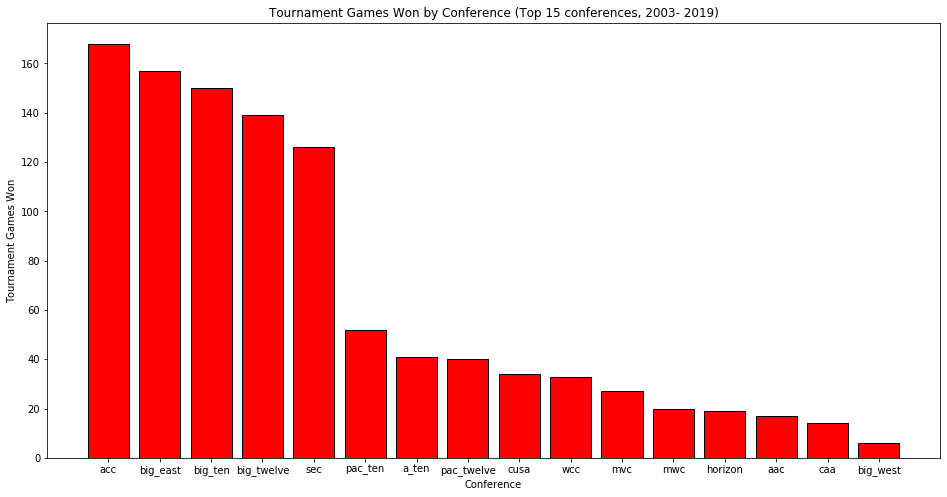

In [37]:
conference_wins = tourney_wins.groupby(["conf"]).games_won.sum().sort_values(ascending = False)[:16]
fig, ax = plt.subplots(figsize = (16,8))
ax.bar(x = conference_wins.index, height = conference_wins.values, color = 'r', edgecolor = 'black')
ax.set_title("Tournament Games Won by Conference (Top 15 conferences, 2003- 2019)")
ax.set_xlabel("Conference")
ax.set_ylabel("Tournament Games Won");

There are six conferences (seven on the bar chart, but the PAC-10 and the PAC-12 are the same conference they just added Utah and Colorado) that account for the vast majority of NCAA tournament wins. There is some discrepancy between total wins (the ACC and the Big East have a significant lead over the field), so an idea may be to look at how conferences perform against each other. For now, I will create 6 binary variables representing the Power 6 conferences. Again, this may need to be revisted at some point because clearly Conference USA and the WCC win more games than the Big Sky (1 tournament win in 17 years), but for the sake of model simplicity I will start with just keeping the big 6. If my results are poor, I will consider adding another category (maybe a Group of 5 feature).

In [38]:
conference_dummies = pd.get_dummies(tourney_wins.conf)
power6 = conference_dummies[["acc", "big_east", "big_ten", "big_twelve", "sec"]]
def pac12(s):
    if s == "pac_ten" or s == "pac_twelve":
        return(1)
    else:
        return(0)
pac12 = tourney_wins.conf.map(lambda x: pac12(x))
pac12 = pac12.rename("pac12")
tourney_wins = tourney_wins.drop(columns = ["conf"])
tourney_wins = pd.concat([tourney_wins, power6, pac12], axis = 1)

There are over 100 different ratings system provided since 2003. Right off the bat we need to narrow the field. The first I thing I am going to look for is which systems have been used in all seasons since 2003. This will be an effective way to ensure that I can use the systems in the model. After that, I will take a look at which ratings systems are good predictors and hopefully narrow the field down to a handful.

In [39]:
team_rankings = pd.read_csv("./engineered_data/finalrankings.csv.gz", compression = "gzip")

In [40]:
pd.set_option('max.columns', 200)
team_rankings.head()

,7OT,ACU,ADE,AP,ARG,AUS,AWS,BBT,BCM,BD,BIH,BKM,BLS,BNM,BNT,BOB,BPI,BRZ,BUR,BWE,CJB,CMV,CNG,COL,COX,CPA,CPR,CRO,CRW,D1A,DAV,DC,DC2,DCI,DDB,DES,DII,DOK,DOL,DUN,DWH,EBP,ECK,ENT,ERD,ESR,FAS,FMG,FSH,GRN,GRS,HAS,HAT,HER,HKB,HKS,HOL,HRN,IMS,INC,INP,ISR,JCI,JEN,JJK,JNG,JON,JRT,KBM,KEL,KLK,KMV,KOS,KPI,KPK,KRA,LAB,LAW,LEF,LMC,LOG,LYD,LYN,MAS,MB,MCL,MGS,MGY,MKV,MMG,MOR,MSX,MUZ,MvG,NET,NOL,NOR,OCT,OMY,PEQ,PGH,PH,PIG,PIR,PKL,PMC,POM,PPR,PRR,PTS,REI,REN,REW,RIS,RM,ROG,ROH,RPI,RSE,RSL,RT,RTB,RTH,RTP,RTR,SAG,SAP,SAU,SCR,SE,SEL,SFX,SGR,SIM,SMN,SMS,SP,SPR,SPW,STF,STH,STM,STR,STS,TBD,TMR,TPR,TRK,TRP,TRX,TSR,TW,UCS,UPS,USA,WIL,WLK,WMR,WMV,WOB,WOL,WTE,YAG,ZAM,season,teamID
0,NaN,NaN,NaN,NaN,141.0,NaN,NaN,NaN,NaN,NaN,172.0,NaN,NaN,NaN,NaN,146.0,NaN,161.0,NaN,NaN,NaN,NaN,NaN,162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175.0,97.0,149.0,NaN,156.0,155.0,147.0,NaN,NaN,NaN,NaN,161.0,166.0,NaN,NaN,148.0,NaN,NaN,185.0,NaN,198.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.0,NaN,NaN,NaN,NaN,139.0,NaN,132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.0,NaN,NaN,NaN,NaN,146.0,NaN,NaN,149.0,NaN,154.0,NaN,162.0,155.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,146.0,NaN,NaN,NaN,NaN,NaN,165.0,NaN,NaN,155.0,157.0,156.0,NaN,NaN,2003,1102
1,NaN,NaN,NaN,NaN,180.0,NaN,NaN,NaN,NaN,NaN,177.0,NaN,NaN,NaN,NaN,179.0,NaN,174.0,NaN,NaN,NaN,NaN,NaN,172.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174.0,165.0,168.0,NaN,194.0,176.0,128.0,NaN,NaN,NaN,NaN,168.0,172.0,NaN,NaN,176.0,NaN,NaN,167.0,NaN,152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163.0,NaN,NaN,NaN,NaN,161.0,NaN,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,182.0,NaN,NaN,NaN,NaN,168.0,NaN,NaN,172.0,NaN,170.0,NaN,167.0,169.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.0,NaN,NaN,NaN,NaN,NaN,172.0,NaN,NaN,177.0,171.0,161.0,NaN,NaN,2003,1103
2,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,NaN,NaN,35.0,NaN,34.0,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0,43.0,33.0,NaN,51.0,34.0,36.0,NaN,NaN,NaN,NaN,40.0,50.0,NaN,NaN,37.0,NaN,NaN,60.0,NaN,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,NaN,NaN,NaN,NaN,35.0,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,NaN,NaN,NaN,NaN,31.0,NaN,NaN,37.0,NaN,32.0,NaN,41.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,NaN,NaN,NaN,NaN,NaN,36.0,NaN,NaN,37.0,37.0,28.0,NaN,NaN,2003,1104
3,NaN,NaN,NaN,NaN,307.0,NaN,NaN,NaN,NaN,NaN,312.0,NaN,NaN,NaN,NaN,313.0,NaN,305.0,NaN,NaN,NaN,NaN,NaN,310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315.0,306.0,315.0,NaN,314.0,309.0,309.0,NaN,NaN,NaN,NaN,313.0,298.0,NaN,NaN,307.0,NaN,NaN,297.0,NaN,310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.0,NaN,NaN,NaN,NaN,310.0,NaN,309.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,307.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,313.0,NaN,NaN,NaN,NaN,312.0,NaN,NaN,312.0,NaN,312.0,NaN,314.0,312.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,289.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315.0,NaN,NaN,NaN,NaN,NaN,310.0,NaN,NaN,312.0,311.0,299.0,NaN,NaN,2003,1105
4,NaN,NaN,NaN,NaN,252.0,NaN,NaN,NaN,NaN,NaN,269.0,NaN,NaN,NaN,NaN,265.0,NaN,219.0,NaN,NaN,NaN,NaN,NaN,256.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266.0,305.0,269.0,NaN,245.0,259.0,283.0,NaN,NaN,NaN,NaN,279.0,227.0,NaN,NaN,245.0,NaN,NaN,198.0,NaN,272.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.0,NaN,NaN,NaN,NaN,255.0,NaN,294.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [41]:
all_seasons = team_rankings.season.unique()

In [42]:
from collections import Counter
all_rankings = []
for season in all_seasons:
    seasonDf = team_rankings[team_rankings.season == season].drop(columns = ["season", "teamID"])
    all_rankings += list(seasonDf.dropna(how = "all", axis = 1).columns)
count = Counter(all_rankings)
count.most_common()[:15]

[('AP', 17),
 ('COL', 17),
 ('DOL', 17),
 ('MOR', 17),
 ('POM', 17),
 ('RTH', 17),
 ('SAG', 17),
 ('USA', 17),
 ('WLK', 17),
 ('WOL', 17),
 ('BIH', 16),
 ('RPI', 16),
 ('WOB', 16),
 ('CNG', 16),
 ('SEL', 15)]

In [43]:
all_years = [i[0] for i in count.most_common()[:10]]
reduced_rankings = team_rankings[all_years + ["teamID", "season"]]
reduced_rankings.head()

,AP,COL,DOL,MOR,POM,RTH,SAG,USA,WLK,WOL,teamID,season
0,NaN,162.0,175.0,132.0,160.0,146.0,149.0,NaN,165.0,157.0,1102,2003
1,NaN,172.0,174.0,139.0,163.0,168.0,172.0,NaN,172.0,171.0,1103,2003
2,NaN,43.0,39.0,26.0,33.0,31.0,37.0,NaN,36.0,37.0,1104,2003
3,NaN,310.0,315.0,309.0,307.0,312.0,312.0,NaN,310.0,311.0,1105,2003
4,NaN,256.0,266.0,294.0,263.0,274.0,268.0,NaN,254.0,270.0,1106,2003


In [44]:
tourney_wins = tourney_wins.merge(reduced_rankings, how = 'left', left_on = ["season", "teamID"],
                                 right_on = ["season", "teamID"])
tourney_wins.head()

,season,teamID,games_won,seedN,DRB_DIF,ORB_DIF,PPG,PPP,TRB_DIF,ast_TO,e_fg,fg,free_throw_pct,opp_PPG,opp_PPP,opp_ast_TO,opp_efg,opp_fg,opp_three_point_pct,opp_trueshooting,three_point_pct,total_point_differential,true_shooting,acc,big_east,big_ten,big_twelve,sec,pac12,AP,COL,DOL,MOR,POM,RTH,SAG,USA,WLK,WOL
0,2003,1411,0,16,58,37,72.800000,0.878704,95,0.932166,0.501206,0.447527,0.619952,70.833333,0.853660,0.960465,0.487307,0.424945,0.325180,0.515957,0.320721,59,0.538334,0,0,0,0,0,0,NaN,212.0,239.0,293.0,268.0,256.0,257.0,NaN,240.0,246.0
1,2003,1436,0,16,112,98,67.793103,0.863235,210,1.009804,0.491667,0.444444,0.657848,63.137931,0.841808,1.021220,0.477458,0.413275,0.329582,0.509154,0.340757,135,0.525815,0,0,0,0,0,0,NaN,144.0,156.0,187.0,144.0,182.0,158.0,NaN,153.0,177.0
2,2003,1272,0,7,69,50,74.517241,0.888511,119,1.205000,0.496264,0.437931,0.653614,65.827586,0.802290,0.883295,0.453218,0.402265,0.322034,0.491392,0.348797,252,0.531700,0,0,0,0,0,0,19.0,19.0,21.0,23.0,20.0,19.0,24.0,22.0,21.0,19.0
3,2003,1166,0,6,60,-6,79.242424,0.995114,54,1.258503,0.568829,0.499473,0.692890,64.333333,0.806783,0.724689,0.475630,0.431544,0.341102,0.513189,0.389053,492,0.597895,0,0,0,0,0,0,15.0,18.0,18.0,33.0,27.0,22.0,18.0,15.0,19.0,17.0
4,2003,1301,0,9,18,-24,72.400000,0.945927,-6,1.032864,0.530937,0.456250,0.770358,68.000000,0.882032,0.858770,0.494981,0.441029,0.337255,0.544337,0.354074,132,0.580699,1,0,0,0,0,0,NaN,56.0,49.0,31.0,48.0,42.0,46.0,NaN,51.0,47.0


I want to now experiment with different ways of replacing the null values in the AP and the USA polls. The obvious solution is to create a binary variable: is_top25AP and is_top25USA. However, this does not account for the difference between the highest ranked team and the 25th ranked team. I will therefore experiment with two different approaches: the binary approach and filling nulls with a value like -1. __UPDATE__: For simplicity of viewing, I changed the value to 30. 

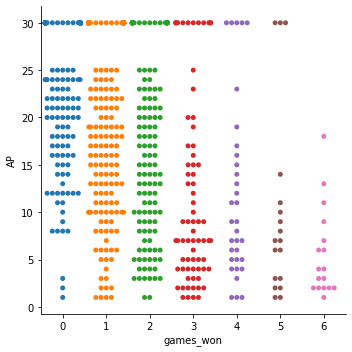

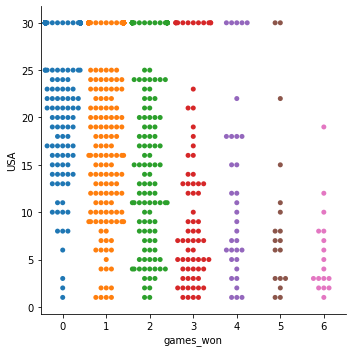

In [45]:
tourney_wins["AP"] = tourney_wins["AP"].fillna(30)
tourney_wins["USA"] = tourney_wins["USA"].fillna(30)

sns.catplot(x="games_won", y="AP",
            kind="swarm", data=tourney_wins)

sns.catplot(x="games_won", y="USA",
            kind="swarm", data=tourney_wins);

It is pretty clear that where teams are ranked within the AP and USA top 25s does matter, and thus a binary feature to capture these will probably be insufficient. Every single winner has come from the top 20, all but one have come from the top 15 and the majority are in the top 5 so clearly these rankings are important. However, possibly splitting into multiple binary features may do the trick, as this eliminates the issue of how to assign a value to the teams that fall outside of the top 25. 

In [46]:
rankings = tourney_wins[["games_won", "AP", "COL", "DOL", "MOR", "POM", "RTH", "SAG", "USA", "WLK", "WOL"]]

rankings_corr = rankings.corr().abs()
all_correlated = rankings_corr.where(np.triu(np.ones(rankings_corr.shape), k = 1).astype(np.bool)).\
stack().sort_values(ascending = False)

games_won_correlation = []
for i in all_correlated.index:
    if "games_won" in i:
        games_won_correlation.append(i)

games_won_correlation = all_correlated[games_won_correlation]

In [47]:
games_won_correlation

games_won  AP     0.615989
           USA    0.615298
           MOR    0.410846
           SAG    0.404262
           RTH    0.403009
           WLK    0.401898
           POM    0.401399
           COL    0.392729
           DOL    0.390475
           WOL    0.387394
dtype: float64

In [48]:
all_correlated

AP         USA    0.989795
SAG        WLK    0.988913
COL        WOL    0.987957
RTH        SAG    0.987694
DOL        WOL    0.986717
COL        DOL    0.986611
POM        SAG    0.986432
DOL        RTH    0.981350
RTH        WLK    0.979749
COL        RTH    0.978170
POM        WLK    0.977960
DOL        SAG    0.977266
           WLK    0.976982
POM        RTH    0.975241
COL        WLK    0.974891
RTH        WOL    0.973357
MOR        POM    0.969766
WLK        WOL    0.969726
COL        SAG    0.969039
MOR        SAG    0.968096
SAG        WOL    0.965313
DOL        POM    0.962688
MOR        RTH    0.961195
           WLK    0.955052
COL        POM    0.950560
POM        WOL    0.947433
DOL        MOR    0.935695
COL        MOR    0.927628
MOR        WOL    0.918727
games_won  AP     0.615989
           USA    0.615298
COL        USA    0.533733
AP         COL    0.533328
USA        WOL    0.526966
DOL        USA    0.526583
AP         DOL    0.526488
           WOL    0.526232
 

As is to be expected, all rating systems are highly correlated with one another. However, the highest top 25 system correlation (even with a MINISCULE difference) is the AP top 25, and the highest not-top 25 system is the Moore ratings. This actually works out well, because of the all ratings system, the AP top 25 and the Moore system are among the least correlated with each other. Thus, going forward, I will only keep the AP Top 25 and the Moore system (at least in initial modeling). 

I do still need to alter the AP feature. I'm going to make two bins, a top-10 bin and a top-25 bin. 

In [49]:
def AP_top10(x):
    if x <= 10.0:
        return(1)
    else:
        return(0)
def AP_top25(x):
    if 10.0 < x <= 25.0:
        return(1)
    else:
        return(0)

tourney_wins["AP_top10"] = tourney_wins["AP"].map(lambda x: AP_top10(x))
tourney_wins["AP_top25"] = tourney_wins["AP"].map(lambda x: AP_top25(x))
tourney_wins = tourney_wins.drop(columns = ["USA", "AP", "COL", "DOL", "POM", "RTH", "SAG", "WLK", "WOL"])

In [50]:
tourney_wins.head()

,season,teamID,games_won,seedN,DRB_DIF,ORB_DIF,PPG,PPP,TRB_DIF,ast_TO,e_fg,fg,free_throw_pct,opp_PPG,opp_PPP,opp_ast_TO,opp_efg,opp_fg,opp_three_point_pct,opp_trueshooting,three_point_pct,total_point_differential,true_shooting,acc,big_east,big_ten,big_twelve,sec,pac12,MOR,AP_top10,AP_top25
0,2003,1411,0,16,58,37,72.800000,0.878704,95,0.932166,0.501206,0.447527,0.619952,70.833333,0.853660,0.960465,0.487307,0.424945,0.325180,0.515957,0.320721,59,0.538334,0,0,0,0,0,0,293.0,0,0
1,2003,1436,0,16,112,98,67.793103,0.863235,210,1.009804,0.491667,0.444444,0.657848,63.137931,0.841808,1.021220,0.477458,0.413275,0.329582,0.509154,0.340757,135,0.525815,0,0,0,0,0,0,187.0,0,0
2,2003,1272,0,7,69,50,74.517241,0.888511,119,1.205000,0.496264,0.437931,0.653614,65.827586,0.802290,0.883295,0.453218,0.402265,0.322034,0.491392,0.348797,252,0.531700,0,0,0,0,0,0,23.0,0,1
3,2003,1166,0,6,60,-6,79.242424,0.995114,54,1.258503,0.568829,0.499473,0.692890,64.333333,0.806783,0.724689,0.475630,0.431544,0.341102,0.513189,0.389053,492,0.597895,0,0,0,0,0,0,33.0,0,1
4,2003,1301,0,9,18,-24,72.400000,0.945927,-6,1.032864,0.530937,0.456250,0.770358,68.000000,0.882032,0.858770,0.494981,0.441029,0.337255,0.544337,0.354074,132,0.580699,1,0,0,0,0,0,31.0,0,0


In [51]:
tourney_wins.to_csv("./engineered_data/tournament_teams_with_metrics.csv.gz", index = False,
                   compression = "gzip")

I have now assembled a feature set for each tournament team since 2003. The next step is to merge this with tournament matchups between 2003 and 2019.

In [53]:
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,2003,134,1421,92,1411,84,N,1
1,2003,136,1112,80,1436,51,N,0
2,2003,136,1113,84,1272,71,N,0
3,2003,136,1141,79,1166,73,N,0
4,2003,136,1143,76,1301,74,N,1


In [54]:
game_winners = tourney_results.drop(columns = ["WLoc", "NumOT"])
game_losers = tourney_results.drop(columns = ["WLoc", "NumOT"])

In [55]:
game_winners = game_winners.merge(tourney_wins, how = 'left', left_on = ["Season", "WTeamID"], 
                                 right_on = ["season", "teamID"])
game_winners.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 38 columns):
Season                      1115 non-null int64
DayNum                      1115 non-null int64
WTeamID                     1115 non-null int64
WScore                      1115 non-null int64
LTeamID                     1115 non-null int64
LScore                      1115 non-null int64
season                      1115 non-null int64
teamID                      1115 non-null int64
games_won                   1115 non-null int64
seedN                       1115 non-null int32
DRB_DIF                     1115 non-null int64
ORB_DIF                     1115 non-null int64
PPG                         1115 non-null float64
PPP                         1115 non-null float64
TRB_DIF                     1115 non-null int64
ast_TO                      1115 non-null float64
e_fg                        1115 non-null float64
fg                          1115 non-null float64
free_throw_pct     

In [56]:
game_losers = game_losers.merge(tourney_wins, how = 'left', left_on = ["Season", "LTeamID"], 
                                 right_on = ["season", "teamID"])
game_losers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 38 columns):
Season                      1115 non-null int64
DayNum                      1115 non-null int64
WTeamID                     1115 non-null int64
WScore                      1115 non-null int64
LTeamID                     1115 non-null int64
LScore                      1115 non-null int64
season                      1115 non-null int64
teamID                      1115 non-null int64
games_won                   1115 non-null int64
seedN                       1115 non-null int32
DRB_DIF                     1115 non-null int64
ORB_DIF                     1115 non-null int64
PPG                         1115 non-null float64
PPP                         1115 non-null float64
TRB_DIF                     1115 non-null int64
ast_TO                      1115 non-null float64
e_fg                        1115 non-null float64
fg                          1115 non-null float64
free_throw_pct     

In [57]:
game_winners = game_winners.drop(columns = ["season", "teamID", "games_won"])
game_losers = game_losers.drop(columns = ["season", "teamID", "games_won"])

In [58]:
change_winners = list(game_winners.columns[6:])
change_losers = list(game_losers.columns[6:])

In [59]:
for i in range(len(change_winners)):
    change_winners[i] = "W" + change_winners[i]
    change_losers[i] = "L" + change_losers[i]

original_cols = list(game_winners.columns[:6])
winner_cols = original_cols + change_winners
loser_cols = original_cols + change_losers

In [62]:
game_winners.columns = winner_cols
game_losers.columns = loser_cols

In [63]:
game_losers.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,LseedN,LDRB_DIF,LORB_DIF,LPPG,LPPP,LTRB_DIF,Last_TO,Le_fg,Lfg,Lfree_throw_pct,Lopp_PPG,Lopp_PPP,Lopp_ast_TO,Lopp_efg,Lopp_fg,Lopp_three_point_pct,Lopp_trueshooting,Lthree_point_pct,Ltotal_point_differential,Ltrue_shooting,Lacc,Lbig_east,Lbig_ten,Lbig_twelve,Lsec,Lpac12,LMOR,LAP_top10,LAP_top25
0,2003,134,1421,92,1411,84,16,58,37,72.800000,0.878704,95,0.932166,0.501206,0.447527,0.619952,70.833333,0.853660,0.960465,0.487307,0.424945,0.325180,0.515957,0.320721,59,0.538334,0,0,0,0,0,0,293.0,0,0
1,2003,136,1112,80,1436,51,16,112,98,67.793103,0.863235,210,1.009804,0.491667,0.444444,0.657848,63.137931,0.841808,1.021220,0.477458,0.413275,0.329582,0.509154,0.340757,135,0.525815,0,0,0,0,0,0,187.0,0,0
2,2003,136,1113,84,1272,71,7,69,50,74.517241,0.888511,119,1.205000,0.496264,0.437931,0.653614,65.827586,0.802290,0.883295,0.453218,0.402265,0.322034,0.491392,0.348797,252,0.531700,0,0,0,0,0,0,23.0,0,1
3,2003,136,1141,79,1166,73,6,60,-6,79.242424,0.995114,54,1.258503,0.568829,0.499473,0.692890,64.333333,0.806783,0.724689,0.475630,0.431544,0.341102,0.513189,0.389053,492,0.597895,0,0,0,0,0,0,33.0,0,1
4,2003,136,1143,76,1301,74,9,18,-24,72.400000,0.945927,-6,1.032864,0.530937,0.456250,0.770358,68.000000,0.882032,0.858770,0.494981,0.441029,0.337255,0.544337,0.354074,132,0.580699,1,0,0,0,0,0,31.0,0,0


In [64]:
merge_cols = ["Season", "DayNum", "WTeamID", "WScore", "LTeamID", "LScore"]
final_tourney = game_winners.merge(game_losers, how = 'left', left_on = merge_cols, right_on = merge_cols)

In [65]:
final_tourney.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 64 columns):
Season                       1115 non-null int64
DayNum                       1115 non-null int64
WTeamID                      1115 non-null int64
WScore                       1115 non-null int64
LTeamID                      1115 non-null int64
LScore                       1115 non-null int64
WseedN                       1115 non-null int32
WDRB_DIF                     1115 non-null int64
WORB_DIF                     1115 non-null int64
WPPG                         1115 non-null float64
WPPP                         1115 non-null float64
WTRB_DIF                     1115 non-null int64
Wast_TO                      1115 non-null float64
We_fg                        1115 non-null float64
Wfg                          1115 non-null float64
Wfree_throw_pct              1115 non-null float64
Wopp_PPG                     1115 non-null float64
Wopp_PPP                     1115 non-null flo

In [66]:
final_tourney.to_csv("./engineered_data/tournament_modeling2003-2019.csv.gz", index = False,
                    compression = "gzip")

This dataset is ready for modeling. In the modeling notebook I will deal with how to generate the target feature. 

# Regular Season Game Modeling- STATISTICS BASED

With the wealth of different data sources we have to choose from, the critical distinction becomes what is useful in a model. When I used end of season data along with rankings and seeds, the model was only making decisions based on seeds and rankings. These are the most correlated with tournament success, and the primary weight will be on that model's predictions. However: Betting chalk (taking the favorite in every game) is not going to win me any competitions (actually it probably would, but that's no fun). My idea is simple: build several different "weak learner" models and train a strong model on top of them. If I train one model using in-game statistics, one model using rankings and seeds, and another using conference matchups, with the correct weight placed on each model I believe I could optimize my results.

The first step in generating a statistics based model is simple: I need to team statistics on any given day of the season. I wrote an object to do this earlier in the notebook. I have elected to extract one of the core functions from that object and use it outside of the SeasonStatExtractor class because unlike in the class instance above where the wrapper function was submitting tasks to the processors, I want to call the ProcessPoolExecutor ON the wrapper function I wrote and the ProcessPoolExecutor cannot operate on class instances. This is the most computationally heavy feature engineering I will do, so for the interest of time multiprocessing is essential.

In [57]:
season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [45]:
def create_advanced_stats(teamID, partial):
    def get_base_stats(teamID, partial):
        offensive = {}
        defensive = {}

        offensive["TO"] = 0
        offensive["FGA"] = 0
        offensive["FTA"] = 0
        offensive["FTM"] = 0
        offensive["FGM"] = 0
        offensive["FGM3"] = 0
        offensive["FGA3"] = 0
        offensive["Points"] = 0
        offensive["TDRB"] = 0
        offensive["TORB"] = 0
        offensive["TA"] = 0

        defensive["TO"] = 0
        defensive["FGA"] = 0
        defensive["FGM"] = 0
        defensive["FTA"] = 0
        defensive["FTM"] = 0
        defensive["FGM3"] = 0
        defensive["FGA3"] = 0
        defensive["Points"] = 0
        defensive["TDRB"] = 0
        defensive["TORB"] = 0
        defensive["TA"] = 0

        won = partial[partial.WTeamID == teamID]
        lose = partial[partial.LTeamID == teamID]

        offensive["n_games"] = len(won) + len(lose)

        if len(won) != 0:
            offensive["TO"] += won.WTO.sum()
            offensive["FGA"] += won.WFGA.sum()
            offensive["FTA"] += won.WFTA.sum()
            offensive["FTM"] += won.WFTM.sum()
            offensive["FGM"] += won.WFGM.sum()
            offensive["FGM3"] += won.WFGM3.sum()
            offensive["FGA3"] += won.WFGA3.sum()
            offensive["Points"] += won.WScore.sum()
            offensive["TDRB"] += won.WDR.sum()
            offensive["TORB"] += won.WOR.sum()
            offensive["TA"] += won.WAst.sum()

            defensive["TO"] += won.LTO.sum()
            defensive["FGA"] += won.LFGA.sum()
            defensive["FGM"] += won.LFGM.sum()
            defensive["FTA"] += won.LFTA.sum()
            defensive["FTM"] += won.LFTM.sum()
            defensive["FGM3"] += won.LFGM3.sum()
            defensive["FGA3"] += won.LFGA3.sum()
            defensive["Points"] += won.LScore.sum()
            defensive["TDRB"] += won.LDR.sum()
            defensive["TORB"] += won.LOR.sum()
            defensive["TA"] += won.LAst.sum()

        if len(lose) != 0:
            offensive["TO"] += lose.LTO.sum()
            offensive["FGA"] += lose.LFGA.sum()
            offensive["FTA"] += lose.LFTA.sum()
            offensive["FTM"] += lose.LFTM.sum()
            offensive["FGM"] += lose.LFGM.sum()
            offensive["FGM3"] += lose.LFGM3.sum()
            offensive["FGA3"] += lose.LFGA3.sum()
            offensive["Points"] += lose.LScore.sum()
            offensive["TDRB"] += lose.LDR.sum()
            offensive["TORB"] += lose.LOR.sum()
            offensive["TA"] += lose.LAst.sum()

            defensive["TO"] += lose.WTO.sum()
            defensive["FGA"] += lose.WFGA.sum()
            defensive["FGM"] += lose.WFGM.sum()
            defensive["FTA"] += lose.WFTA.sum()
            defensive["FTM"] += lose.WFTM.sum()
            defensive["FGM3"] += lose.WFGM3.sum()
            defensive["FGA3"] += lose.WFGA3.sum()
            defensive["Points"] += lose.WScore.sum()
            defensive["TDRB"] += lose.WDR.sum()
            defensive["TORB"] += lose.WOR.sum()
            defensive["TA"] += lose.WAst.sum()


        return(offensive, defensive)
    offensive, defensive = get_base_stats(teamID, partial)
    if offensive["n_games"] == 0:
        return({
            "teamID" : teamID,
            "fg" : 0.,
            "e_fg" : 0.,
            "true_shooting" : 0.,
            "three_point_pct" : 0.,
            "free_throw_pct" : 0.,
            "PPP" : 0.,
            "ast_TO" : 0.,
            "PPG" : 0.,
            "opp_fg" : 0.,
            "opp_efg" : 0.,
            "opp_trueshooting" : 0.,
            "opp_three_point_pct" : 0.,
            "opp_PPP" : 0.,
            "opp_ast_TO" : 0.,
            "opp_PPG" : 0.,
            "ORB_DIF" : 0.,
            "DRB_DIF" : 0.,
            "TRB_DIF" : 0.,
            "total_point_differential" : 0.
        })
    advanced_metrics = {}
    advanced_metrics["teamID"] = teamID

    advanced_metrics["fg"] = offensive["FGM"] / offensive["FGA"]
    advanced_metrics["e_fg"] = (offensive["FGM"] + 0.5*offensive["FGM3"]) / offensive["FGA"]
    advanced_metrics["true_shooting"] = offensive["Points"] / (2 * (offensive["FGA"] + 0.44*offensive["FTA"]))
    advanced_metrics["three_point_pct"] = offensive["FGM3"] / offensive["FGA3"]
    advanced_metrics["free_throw_pct"] = offensive["FTM"] / offensive["FTA"]
    advanced_metrics["PPP"] = offensive["Points"] / (offensive["FGA"] + 0.44*offensive["FTA"] + offensive["TO"])
    advanced_metrics["ast_TO"] = offensive["TA"] / offensive["TO"]
    advanced_metrics["PPG"] = offensive["Points"] / offensive["n_games"]

    advanced_metrics["opp_fg"] = defensive["FGM"] / defensive["FGA"]
    advanced_metrics["opp_efg"] = (defensive["FGM"] + 0.5*defensive["FGM3"]) / defensive["FGA"]
    advanced_metrics["opp_trueshooting"] = defensive["Points"] / (2*(defensive["FGA"] + 0.44*defensive["FTA"]))
    advanced_metrics["opp_three_point_pct"] = defensive["FGM3"] / defensive["FGA3"]
    advanced_metrics["opp_PPP"] = defensive["Points"] / (defensive["FGA"] + 0.44*defensive["FTA"] + defensive["TO"])
    advanced_metrics["opp_ast_TO"] = defensive["TA"] / defensive["TO"]
    advanced_metrics["opp_PPG"] = defensive["Points"] / offensive["n_games"]

    advanced_metrics["ORB_DIF"] = offensive["TORB"] - defensive["TORB"]
    advanced_metrics["DRB_DIF"] = offensive["TDRB"] - defensive["TDRB"]
    advanced_metrics["TRB_DIF"] = offensive["TDRB"]+offensive["TORB"] - defensive["TORB"] - defensive["TDRB"]
    advanced_metrics["total_point_differential"] = offensive["Points"] - defensive["Points"]

    return(advanced_metrics)

def get_game_stats(df, season):
    season = df[df.Season == season].reset_index(drop = True)
    all_games = []
    for k in range(len(season)):
        game_observation = {
                            "Season" : season.iloc[k]["Season"],
                           "DayNum" : season.iloc[k]["DayNum"],
                           "WTeamID" : season.iloc[k]["WTeamID"],
                           "WScore" : season.iloc[k]["WScore"],
                           "LTeamID" : season.iloc[k]["LTeamID"],
                            "LScore" : season.iloc[k]["LScore"],
                           "WLoc" : season.iloc[k]["WLoc"]
        }
        winner, loser = season.iloc[k]["WTeamID"], season.iloc[k]["LTeamID"]
        winner_metrics = create_advanced_stats(winner, season.iloc[:k])
        loser_metrics = create_advanced_stats(loser, season.iloc[:k])
        winner_metrics.pop("teamID"), loser_metrics.pop("teamID")
        keys = list(winner_metrics.keys())
        for key in keys:
            winner_metrics["W_" + key] = winner_metrics[key]
            loser_metrics["L_" + key] = loser_metrics[key]
            winner_metrics.pop(key)
            loser_metrics.pop(key)
        game_observation.update(winner_metrics)
        game_observation.update(loser_metrics)
        all_games.append(game_observation)
    new_df = pd.DataFrame(all_games)
    return(new_df)

In [47]:
all_frames = []
seasons = list(season_results.Season.unique())
with ProcessPoolExecutor(max_workers = None) as executor:
    for season in seasons:
        all_frames.append(executor.submit(get_game_stats, season_results, season))
all_frames = [i.result() for i in all_frames]
final = pd.concat(all_frames, axis = 0, sort = True).reset_index(drop = True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in long_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in long_scalars


In [56]:
final.to_csv("./engineered_data/game_level_statistics.csv.gz", compression = "gzip", index = False)

In [5]:
game_level = pd.read_csv("./engineered_data/game_level_statistics.csv.gz", compression = "gzip")

Next, and this is going to be horrible but it must be done, I need to extract each team's ranking throughout the season. Now, from previous feature engineering, I do know that there are only 10 ranking systems that exist for all 17 years of season data that I have, so that at least simplifies it a bit. The main ugliness of this task is going to be trying to coordinate ranking release dates, which vary between rankings and also will not match up with the game days. Let's get ugly.

In [7]:
ordinals.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [8]:
rankings = ["USA", "AP", "COL", "DOL", "POM", "RTH", "SAG", "WLK", "WOL", "MOR"]
for ranking in rankings:
    ranking_df = ordinals[ordinals.SystemName == ranking]
    first_day = ranking_df.RankingDayNum.min()
    ranking_days = ranking_df.RankingDayNum.unique()
    print(ranking_days)
    print()
    print("The {} rankings are first released on day {} of the season".format(ranking, first_day))

[ 37  44  51  57  65  71  79  85  93  99 106 112 120 127 133  13  23  30
  43  50  56  64  78  86  91 105 113 119  16  22  29  58 100 107 114 128
  42  72  92 121   1   8  15  21  36  49  63  77   6  84   9  28   7]

The USA rankings are first released on day 1 of the season
[ 37  44  51  57  65  71  79  85  93  99 106 112 120 127 133  13  23  30
  43  50  56  64  78  86  91 105 113 119  16  22  29  58 100 107 114 128
  42  72  92 121   1   8  15  21  36  49  63  77   6  84   9  28   7]

The AP rankings are first released on day 1 of the season
[ 93  99 106 112 119 127 133  78  86  91 105 113  58  65  71 100 107 114
 120 128  79  85  98  37  43  51  72  92 126  42  57  64  70  77  84  50
  63  49  36  44  28  35  56  30 121]

The COL rankings are first released on day 28 of the season
[ 93  99 106 112 120 127 133  43  50  56  64  71  78  86  91 105 113 119
  58  65 100 107 128  29  42  72  79 114  85  92 121  77  22  36  57  63
  84  44  51  16  23  30  37]

The DOL rankings are first 

In [9]:
def get_ranking_values(df1, df2, d, k, rankings):
    d["index"] = k
    day = df1.iloc[k]["DayNum"]
    season = df1.iloc[k]["Season"]
    winner = df1.iloc[k]["WTeamID"]
    loser = df1.iloc[k]["LTeamID"]
    w_rankings = df2[(df2.TeamID == winner) & (df2.RankingDayNum <= day) & (df2.Season == season)]
    l_rankings = df2[(df2.TeamID == loser) & (df2.RankingDayNum <= day) & (df2.Season == season)]
    for ranking in rankings:
        try:
            d["W_" + ranking] = df2.iloc[w_rankings[w_rankings.SystemName == ranking].\
                                              RankingDayNum.idxmax()].OrdinalRank
        except:
            d["W_" + ranking] = -1
        try:
            d["L_" + ranking] = df2.iloc[l_rankings[l_rankings.SystemName == ranking].\
                                              RankingDayNum.idxmax()].OrdinalRank
        except:
            d["L_" + ranking] = -1
    return(d)

In [24]:
rankings_list = []
for k in range(len(game_level)):
    ranking_dict = {}
    rankings_list.append(get_ranking_values(game_level, ordinals, ranking_dict, k, rankings))

In [28]:
rankings_df = pd.DataFrame(rankings_list)

In [34]:
rankings_df = rankings_df.drop(columns = ["index"])
rankings_df.to_csv("./engineered_data/game_level_rankings.csv.gz", index = False, compression = "gzip")

# Rankings DataFrame work

In [10]:
season = game_level["Season"]
day = game_level["DayNum"]
team_ids = game_level[["LTeamID", "WTeamID"]]
rankings_df = pd.concat([rankings_df, season, day, team_ids], axis = 1)

In [32]:
rankings_df.to_csv("./engineered_data/game_level_rankings.csv.gz", compression = "gzip", index = False)

In [6]:
rankings_df = pd.read_csv("./engineered_data/game_level_rankings.csv.gz", compression = "gzip")
game_level = pd.read_csv("./engineered_data/game_level_statistics.csv.gz", compression = "gzip")

In [8]:
for season in rankings_df.Season.unique():
    print("For the season {}, the following days have no rankings:".format(season))
    print(rankings_df[(rankings_df.Season == season) & (rankings_df.W_POM == -1)].DayNum.unique())
    print()

For the season 2003, the following days have no rankings:
[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36]

For the season 2004, the following days have no rankings:
[10 11 12]

For the season 2005, the following days have no rankings:
[10 11 12 13 14 15]

For the season 2006, the following days have no rankings:
[ 8  9 10 11 12 14 19 26 30 31 33 34 40 42 67 70 73 75 77 80 82]

For the season 2007, the following days have no rankings:
[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 36 40 47 50 53 54 60 61 64]

For the season 2008, the following days have no rankings:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 54]

For the season 2009, the following days have no rankings:
[  7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  24  41  43
  55  59  82  89  96 103 105 108 110 113 116 117 118 124 125]

For the season 2010, the f

In [9]:
all_seasons = list(rankings_df.Season.unique())

In [20]:
ranking_cols = ["W_COL", "L_COL", "W_DOL", "L_DOL", "W_POM", "L_POM", "W_RTH", "L_RTH", "W_SAG", "L_SAG",
               "W_WLK", "L_WLK", "W_WOL", "L_WOL", "W_MOR", "L_MOR"]
problem_values = []
for season in all_seasons:
    for column in ranking_cols:
        missing_values = rankings_df[(rankings_df.Season == season) & (rankings_df[column] == -1)]
        system = column.split("_")[1]
        if column[0] == "W":
            for k in missing_values.index:
                team = rankings_df.iloc[k]["WTeamID"]
                not_missing = rankings_df[( (rankings_df.Season == season) & 
                                           (rankings_df[column] != -1) & (rankings_df.WTeamID == team)) |
                   ( (rankings_df.Season == season) & (rankings_df["L_" + system] != -1) & 
                    (rankings_df.LTeamID == team))]
                if len(not_missing) == 0:
                    problem_values.append((k, column))
                    continue
                imputable_values = not_missing[not_missing.index > k]
                if len(imputable_values) > 0:
                    index = imputable_values.index.min()
                else:
                    index = imputable_values.index.max()
                try:
                    if rankings_df.iloc[index]["WTeamID"] == team:
                        rankings_df.at[k, column] = rankings_df.iloc[index][column]
                    else:
                        rankings_df.at[k, column] = rankings_df.iloc[index]["L_" + system]
                except:
                    print(k, column)
        elif column[0] == "L":
            for k in missing_values.index:
                team = rankings_df.iloc[k]["LTeamID"]
                not_missing = rankings_df[( (rankings_df.Season == season) & 
                                           (rankings_df["W_" + system] != -1) &
                                           (rankings_df.WTeamID == team) ) |
                                         ( (rankings_df.Season == season) &
                                         (rankings_df[column] != -1) &
                                         (rankings_df.LTeamID == team))]
                if len(not_missing) == 0:
                    problem_values.append((k, column))
                    continue
                imputable_values = not_missing[not_missing.index > k]
                if len(imputable_values) > 0:
                    index = imputable_values.index.min()
                else:
                    index = imputable_values.index.max()
                try:
                    if rankings_df.iloc[index]["WTeamID"] == team:
                        rankings_df.at[k, column] = rankings_df.iloc[index]["W_" + system]
                    else:
                        rankings_df.at[k, column] = rankings_df.iloc[index][column]
                except:
                    print(k, column)
    print("{} season is completed".format(season))

2003 season is completed
2004 season is completed
2005 season is completed
2006 season is completed
2007 season is completed
2008 season is completed
2009 season is completed
2010 season is completed
2011 season is completed
2012 season is completed
2013 season is completed
2014 season is completed
2015 season is completed
2016 season is completed
2017 season is completed
2018 season is completed
2019 season is completed


In [40]:
problem_columns = [i[1] for i in problem_values]
problem_indices = [i[0] for i in problem_values]

There are 345 observations that do not have (for whatever reason) rankings. After looking at the teams, I have determined all the teams are either new to D1 or very small programs. So, I will be imputing the max ranking value for each of these columns into these numbers (the lowest ranking possible).

In [44]:
for k in range(len(problem_columns)):
    season = rankings_df.iloc[problem_indices[k]]["Season"]
    col = problem_columns[k]
    max_rating = rankings_df[(rankings_df.Season == season)][col].max()
    rankings_df.at[problem_indices[k], col] = max_rating

In [49]:
for col in ranking_cols:
    if len(rankings_df[rankings_df[col] == -1]) != 0:
        print(col)

In [50]:
rankings_df.head()

,W_USA,L_USA,W_AP,L_AP,W_COL,L_COL,W_DOL,L_DOL,W_POM,L_POM,...,W_WLK,L_WLK,W_WOL,L_WOL,W_MOR,L_MOR,Season,DayNum,LTeamID,WTeamID
0,-1,-1,-1,-1,27,9,27,11,15,20,...,14,23,5,21,13,4,2003,10,1328,1104
1,-1,-1,-1,-1,52,37,72,16,41,40,...,80,110,11,35,40,57,2003,10,1393,1272
2,-1,-1,-1,-1,18,47,10,52,25,46,...,33,24,38,85,52,36,2003,11,1437,1266
3,-1,-1,-1,-1,155,169,144,194,173,267,...,171,244,215,249,188,235,2003,11,1457,1296
4,-1,-1,-1,-1,11,12,9,13,9,49,...,20,65,19,20,18,29,2003,11,1208,1400


In [51]:
def get_dummies_AP_USA(n):
    if n != -1:
        return(1)
    else:
        return(0)
rankings_df["W_AP_"] = rankings_df.W_AP.map(lambda x: get_dummies_AP_USA(x))
rankings_df["L_AP_"] = rankings_df.L_AP.map(lambda x: get_dummies_AP_USA(x))
rankings_df["W_USA_"] = rankings_df.W_USA.map(lambda x: get_dummies_AP_USA(x))
rankings_df["L_USA_"] = rankings_df.L_USA.map(lambda x: get_dummies_AP_USA(x))

rankings_df = rankings_df.drop(columns = ["W_USA", "L_USA", "W_AP", "L_AP"])

In [57]:
full_ = game_level.merge(rankings_df, how = "left", left_on = ["Season", "DayNum", "LTeamID", "WTeamID"],
                        right_on = ["Season", "DayNum", "LTeamID", "WTeamID"])

In [60]:
conf_dict = {}
conf2003 = conferences[conferences.Season > 2002].reset_index(drop = True)
for season in conf2003.Season.unique():
    s = str(season)
    conf_dict[s] = {}
    season_frame = conf2003[conf2003.Season == season].reset_index(drop = True)
    for k in range(len(season_frame)):
        conf_dict[s][season_frame.iloc[k]["TeamID"]] = season_frame.iloc[k]["ConfAbbrev"]

In [62]:
winning_teams = []
losing_teams = []
for season in full_.Season.unique():
    season_frame = full_[full_.Season == season].reset_index(drop = True)
    working = conf_dict[str(season)]
    winners = season_frame.WTeamID.map(working)
    losers = season_frame.LTeamID.map(working)
    winning_teams.append(winners)
    losing_teams.append(losers)

In [73]:
all_winners = pd.concat(winning_teams, axis = 0).reset_index(drop = True)
all_losers = pd.concat(losing_teams, axis = 0).reset_index(drop = True)

In [77]:
def get_power6(s):
    power6 = ["sec", "big_ten", "big_twelve", "acc", "pac_ten", "pac_twelve", "big_east"]
    if s in power6:
        return(1)
    else:
        return(0)

power6_winners = all_winners.map(lambda x: get_power6(x)).rename("W_Conf")
power6_losers = all_losers.map(lambda x: get_power6(x)).rename("L_Conf")

In [79]:
full_ = pd.concat([full_, power6_winners, power6_losers], axis = 1)

In [6]:
full_ = pd.read_csv("./engineered_data/all_game_level.csv.gz", compression = "gzip")

In [8]:
all_seasons = list(full_.Season.unique())

In [11]:
pd.set_option("max.columns", 100)
full_.head()

,DayNum,LScore,LTeamID,L_DRB_DIF,L_ORB_DIF,L_PPG,L_PPP,L_TRB_DIF,L_ast_TO,L_e_fg,L_fg,L_free_throw_pct,L_opp_PPG,L_opp_PPP,L_opp_ast_TO,L_opp_efg,L_opp_fg,L_opp_three_point_pct,L_opp_trueshooting,L_three_point_pct,L_total_point_differential,L_true_shooting,Season,WLoc,WScore,WTeamID,W_DRB_DIF,W_ORB_DIF,W_PPG,W_PPP,W_TRB_DIF,W_ast_TO,W_e_fg,W_fg,W_free_throw_pct,W_opp_PPG,W_opp_PPP,W_opp_ast_TO,W_opp_efg,W_opp_fg,W_opp_three_point_pct,W_opp_trueshooting,W_three_point_pct,W_total_point_differential,W_true_shooting,W_COL,L_COL,W_DOL,L_DOL,W_POM,L_POM,W_RTH,L_RTH,W_SAG,L_SAG,W_WLK,L_WLK,W_WOL,L_WOL,W_MOR,L_MOR,W_AP_,L_AP_,W_USA_,L_USA_,W_Conf,L_Conf
0,10,62,1328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003,N,68,1104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27,9,27,11,15,20,9,25,11,27,14,23,5,21,13,4,0,0,0,0,1,1
1,10,63,1393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003,N,70,1272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52,37,72,16,41,40,15,20,61,60,80,110,11,35,40,57,0,0,0,0,0,1
2,11,61,1437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003,N,73,1266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,47,10,52,25,46,34,71,32,54,33,24,38,85,52,36,0,0,0,0,0,1
3,11,50,1457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003,N,56,1296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,155,169,144,194,173,267,199,265,190,248,171,244,215,249,188,235,0,0,0,0,0,0
4,11,71,1208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003,N,77,1400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,12,9,13,9,49,19,21,18,46,20,65,19,20,18,29,0,0,0,0,1,1


In [18]:
def get_wins(df):
    all_seasons = list(df.Season.unique())
    observationsW = []
    observationsL = []
    for season in all_seasons:
        season_frame = df[df.Season == season].reset_index(drop = True)
        for k in range(len(season_frame)):
            d_w = {}
            d_l = {}
            winner = season_frame.iloc[k]["WTeamID"]
            loser = season_frame.iloc[k]["LTeamID"]
            day = season_frame.iloc[k]["DayNum"]
            d_w["W_power6_wins"] = len(season_frame[(season_frame.WTeamID == winner) & 
                                                   (season_frame.L_Conf == 1) &
                                                   (season_frame.DayNum < day)])
            d_w["W_top50_wins"] = len(season_frame[(season_frame.WTeamID == winner) & 
                                                   (season_frame.L_POM <= 50) &
                                                   (season_frame.DayNum < day)])
            d_l["L_power6_wins"] = len(season_frame[(season_frame.WTeamID == loser) & 
                                                    (season_frame.L_Conf == 1) &
                                                   (season_frame.DayNum < day)])
            d_l["L_top50_wins"] = len(season_frame[(season_frame.WTeamID == loser) & 
                                                  (season_frame.L_POM <= 50) &
                                                  (season_frame.DayNum < day)])
            observationsW.append(d_w)
            observationsL.append(d_l)
    return(observationsW, observationsL)
            

In [19]:
oW, oL = get_wins(full_)

In [20]:
W_ranked_wins = pd.DataFrame(oW)
L_ranked_wins = pd.DataFrame(oL)

In [25]:
full_ = pd.concat([full_, W_ranked_wins, L_ranked_wins], axis = 1)

In [26]:
full_.to_csv("./engineered_data/all_game_level.csv.gz", index = False, compression = "gzip")